# Quantiles & histograms
By the end of this lecture you will be able to:
- calculate a quantile on a `DataFrame`
- calculate a quantile on an expression
- calculate and visualise a histogram

In [1]:
import polars as pl
import matplotlib.pyplot as plt

In [2]:
csv_file = "../Files/Sample_Superstore.csv"

In [3]:
df = pl.read_csv(csv_file)

In [4]:
df.head(3)

Row_ID,Order_ID,Order_Date,Ship_Date,Ship_Mode,Customer_ID,Customer_Name,Segment,Country,City,State,Postal_Code,Region,Product_ID,Category,Sub_Category,Product_Name,Sales,Quantity,Discount,Profit
i64,str,str,str,str,str,str,str,str,str,str,i64,str,str,str,str,str,f64,i64,f64,f64
1,null,null,"""11-11-2016""","""Second Class""","""CG-12520""","""Claire Gute""","""Consumer""","""United States""","""Henderson""","""Kentucky""",42420,"""South""","""FUR-BO-10001798""","""Furniture""","""Bookcases""","""Bush Somerset Collection Bookc…",261.96,2,0.0,41.9136
2,"""CA-2016-152156""","""08-11-2016""","""11-11-2016""","""Second Class""","""CG-12520""","""Claire Gute""","""Consumer""","""United States""","""Henderson""","""Kentucky""",42420,"""South""","""FUR-CH-10000454""","""Furniture""","""Chairs""","""Hon Deluxe Fabric Upholstered …",731.94,3,0.0,219.582
3,"""CA-2016-138688""","""12-06-2016""",null,null,"""DV-13045""","""Darrin Van Huff""","""Corporate""",null,"""Los Angeles""","""California""",90036,"""West""","""OFF-LA-10000240""","""Office Supplies""","""Labels""","""Self-Adhesive Address Labels f…",14.62,2,0.0,6.8714


## Quantiles

### Quantiles on a `DataFrame`
We calculate quantiles on a `DataFrame` using the `quantile` function. To get the 90th percentile we do:

In [5]:
df.quantile(0.9)

Row_ID,Order_ID,Order_Date,Ship_Date,Ship_Mode,Customer_ID,Customer_Name,Segment,Country,City,State,Postal_Code,Region,Product_ID,Category,Sub_Category,Product_Name,Sales,Quantity,Discount,Profit
f64,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,f64,f64,f64,f64
8995.0,null,null,null,null,null,null,null,null,null,null,94122.0,null,null,null,null,null,572.76,7.0,0.4,89.307


### Quantiles in an expression

We can also calculate quantiles as an expression

In [6]:
(
    df.select(
        pl.col("Profit").quantile(0.9)
    )
)

Profit
f64
89.307


### Multiple quantiles
We can calculate multiple quantiles in an expression using a list comprehension. As expressions are run in parallel this allows us to calculate multiple quantiles in parallel

In [7]:
quantile_list = [0.1,0.5,0.9]
(
    df
    .select(
        [
            pl.col("Profit").quantile(q).alias(f"Profit_quantile_{q}") for q in quantile_list
        ]
    )
)

Profit_quantile_0.1,Profit_quantile_0.5,Profit_quantile_0.9
f64,f64,f64
-15.4764,8.671,89.307


To calculate multiple quantiles on multiple columns we can use `name.suffix` to avoid column name collisions.

In this example we calculate multiple quantiles on all of the floating point columns

In [8]:
quantile_list = [0.1,0.5,0.9]
(
    df.select(
        [
            pl.col(pl.Float64).quantile(q).name.suffix(f"_quantile_{q}") for q in quantile_list
        ]
    )
)

Sales_quantile_0.1,Discount_quantile_0.1,Profit_quantile_0.1,Sales_quantile_0.5,Discount_quantile_0.5,Profit_quantile_0.5,Sales_quantile_0.9,Discount_quantile_0.9,Profit_quantile_0.9
f64,f64,f64,f64,f64,f64,f64,f64,f64
7.896,0.0,-15.4764,54.5,0.2,8.671,572.76,0.4,89.307


As quantiles can be calculated using a fast-track algorithm on sorted columns it may be worth sorting the columns you are calculting multiple quantiles on first

In [9]:
(
    df
    .select(
        pl.col(pl.Float64).sort()
    )
    .select(
        [
            pl.col(pl.Float64).quantile(q).name.suffix(f"_quantile_{q}") for q in quantile_list
        ]
    )
)

Sales_quantile_0.1,Discount_quantile_0.1,Profit_quantile_0.1,Sales_quantile_0.5,Discount_quantile_0.5,Profit_quantile_0.5,Sales_quantile_0.9,Discount_quantile_0.9,Profit_quantile_0.9
f64,f64,f64,f64,f64,f64,f64,f64,f64
7.896,0.0,-15.4764,54.5,0.2,8.671,572.76,0.4,89.307


### Interpolation strategy for quantiles
We can use different interpolation strategies for calculating quantiles:
- nearest 
- higher 
- lower 
- midpoint
- linear

In [10]:
df.select(
    pl.col('Profit').quantile(0.25, interpolation='nearest').alias('Profit_nearest'),
    pl.col('Profit').quantile(0.25, interpolation='linear').alias('Profit_linear')
)

Profit_nearest,Profit_linear
f64,f64
1.728,1.72875


## Histogram

### Histogram method
We can calculate a histogram on a `Series`. Here we get a histogram of the `Profit` column

In [11]:
(
    df["Profit"]
    .hist()
)

breakpoint,category,count
f64,cat,u32
-5099.9826,"""(-6614.977954, -5099.9826]""",1
-3599.9872,"""(-5099.9826, -3599.9872]""",2
-2099.9918,"""(-3599.9872, -2099.9918]""",4
-599.9964,"""(-2099.9918, -599.9964]""",34
899.999,"""(-599.9964, 899.999]""",9907
2399.9944,"""(899.999, 2399.9944]""",35
3899.9898,"""(2399.9944, 3899.9898]""",5
5399.9852,"""(3899.9898, 5399.9852]""",4
6899.9806,"""(5399.9852, 6899.9806]""",1


The columns of the output are:
- `breakpoint` this is the right-hand value of each bin
- `category` which is a categorical column showing the range of each bin
- `count` showing the number of values in each bin

We can instead pass a `list` to specify the `bins`

In [12]:
(
    df['Profit']
    .hist(
        bins=list(range(0,100,10))
    )
)

breakpoint,category,count
f64,cat,u32
10.0,"""(0.0, 10.0]""",3451
20.0,"""(10.0, 20.0]""",1407
30.0,"""(20.0, 30.0]""",737
40.0,"""(30.0, 40.0]""",427
50.0,"""(40.0, 50.0]""",308
60.0,"""(50.0, 60.0]""",257
70.0,"""(60.0, 70.0]""",172
80.0,"""(70.0, 80.0]""",167
90.0,"""(80.0, 90.0]""",151


If we just want to visualise the histogram, we can use the `plot.hist` method. In this case we specify the number of bins

In [13]:
df = df.filter(pl.col('Profit') > 500)

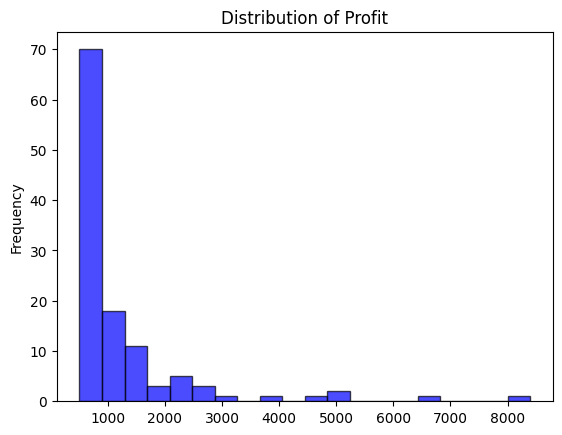

In [14]:
df_pandas = df.to_pandas()

df_pandas['Profit'].plot.hist(bins=20, color='blue', edgecolor='black', alpha=0.7, title='Distribution of Profit')

plt.show()